# Lab 2 - Transfer Learning and Transformers

# Group Information

**Group:** Lab Two Group 1

**Group Members:**

 * Ghaida Al-Atoum
 * Tango Tew
 * Wilma Davis

# General Setup

In [25]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [26]:
import re,string
import time
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import pickle

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, Dense, Dropout, Dense, Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Layer, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib

import transformers
from transformers import AutoTokenizer, TFBertModel

In [27]:
print("Tensorflow version: ", tf.__version__)
print("Keras Version: ", keras.__version__)
print("System Version: ", sys.version)

Tensorflow version:  2.9.2
Keras Version:  2.9.0
System Version:  3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [28]:
LOAD_MODELS = True

## Tensfor Flow Setup

In [29]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [30]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

# Helper Functions

#### plot_learning_curves

In [31]:
METRICS_TO_PLOT = ['fbeta_local', 'loss']
METRICS_IN_HISTORIES = ['accuracy','val_accuracy','fbeta_local', 'val_fbeta_local', 'loss','val_loss']

In [32]:
# model_name : String - used for plot title
# metrics_to_plot : List of metrics to plot their learning curves (i.e. the metric and the val_metric)
# all_metrics : List of metrics available under the history
# history : list of histories saved for every training (.fit) 
def plot_learning_curves(model_name, metrics_to_plot, all_metrics, history):
    combined = history
    if type(history) is not dict:
        combined = combine_histories(all_metrics, history)

    numbers_to_plot = len(metrics_to_plot)
    pyplot.figure(figsize=(25, 10))
    for i in range(0, numbers_to_plot):
        epochs = range(len(combined[metrics_to_plot[i]]))
        pyplot.subplot(1, numbers_to_plot, i+1)
        pyplot.plot(epochs, combined[metrics_to_plot[i]], 'bo')
        pyplot.plot(epochs, combined['val_{}'.format(metrics_to_plot[i])], 'b')
        pyplot.title('Model {}'.format(metrics_to_plot[i]))
        pyplot.ylabel(metrics_to_plot[i])
        pyplot.xlabel('Epoch')
        pyplot.legend(['Train', 'Validation'], loc='upper left')
        
    pyplot.show()

#### bytes_to

In [33]:
# Reference: https://gist.github.com/shawnbutts/3906915
def bytes_to(bytes, to, bsize=1024):
    """convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytes_to(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    for i in range(a[to]):
        r = r / bsize

    return(r)

#### print_gpu_usage

In [34]:
def print_gpu_usage():
    print("GPU Peak Memory: ", bytes_to(tf.config.experimental.get_memory_info('GPU:0')['peak'], 'g'), 'G')
    print("GPU Current Memory Usage: ", bytes_to(tf.config.experimental.get_memory_usage('GPU:0'), 'g'), 'G')

In [35]:
from keras import backend as K

def fbeta_local(y_true, y_pred, beta=0.5):
    y_pred = K.clip(y_pred, 0, 1)
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # a
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1))) # d
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1))) 
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    
    percision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    num = (1 + (beta ** 2)) * percision * recall
    den =  ((beta ** 2) * percision) + recall + K.epsilon()
    return num / den

#### Saving/Loading Models/Weights

In [36]:
def format_model_save_file(model_name):
    return "./models/model_{}.keras".format(model_name)

In [37]:
def save_model(model):
    path = format_model_save_file(model.name)
    model.save(path)

In [38]:
def load_model(model_name, is_bert_layer=False):
    custom_objects = {"fbeta_local":fbeta_local}
    if is_bert_layer:
        custom_objects["TFBertModel"] = transformers.TFBertModel
    return keras.models.load_model(format_model_save_file(model_name), custom_objects=custom_objects)

In [39]:
def format_checkpoint_name(model_name):
    return "./checkpoints/checkpoint_{}.ckpt".format(model_name)

In [40]:
def load_weights_from_checkpoints(model, model_name):
    checkpoint_file = format_checkpoint_name(model_name)
    model.load_weights(checkpoint_file)

In [41]:
def format_history_path_name(model_name):
    return "./histories/history_{}".format(model_name)

In [42]:
def combine_histories(all_metrics, histories):
    if type(histories) is not dict:
        combined = dict()
        for key in all_metrics:
            a=np.array([])
            for x in histories:
                a = np.append(a, x.history[key])
            combined[key] = a
        return combined
    return histories

In [43]:
def append_to_dict_histories(all_metrics, dict_history, histories):
    combined = dict_history
    for key in all_metrics:
        combined[key] = np.append(combined[key], histories.history[key])
    return combined

In [44]:
def save_history(histories, all_metrics, model_name):
    combined_histories = combine_histories(all_metrics, histories)
    file_path = format_history_path_name(model_name)
    with open(file_path, 'wb') as file_p:
        pickle.dump(combined_histories, file_p)

In [45]:
def load_history(model_name):
    file_path = format_history_path_name(model_name)
    with open(file_path, 'rb') as file_p:
        return pickle.load(file_p)

In [46]:
def train_model(model, train_data, train_labels, test_data, test_labels, epochs, batch_size, histories, save_model=True, verbose=1):
    # Calculate the number of batches per epoch
    len_train_data = 0
    if type(train_data) is dict:
        len_train_data = len(train_data[list(train_data.keys())[0]])
    else:
        len_train_data = len(train_data)
        
    print("Length of training data {}".format(len_train_data))
    n_batches = len_train_data / batch_size
    n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=format_checkpoint_name(model.name),
        verbose=verbose,
        save_weights_only=True,
        save_freq=2*n_batches
    )

    print("Training model {} ...".format(model.name))
    history = model.fit(
        train_data, train_labels,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[model_checkpoint_callback],
        validation_data=(test_data, test_labels),
        verbose=verbose #0 = silent, 1 = progress bar, 2 = one line per epoch
    )
    
    if type(histories) is dict:
        print("Histories is a dict - Custom Append")
        histories = append_to_dict_histories(METRICS_IN_HISTORIES, histories, history)
    else:
        print("Appending history to list of histories ")
        histories.append(history)
        
    save_history(histories, METRICS_IN_HISTORIES, model.name)
    print_gpu_usage()
    
    if save_model:
        model_save_path = format_model_save_file(model.name)
        if os.path.exists(model_save_path):
            os.remove(model_save_path)
            
        print("Save Trained Model {} ...".format(model.name))
        model.save(format_model_save_file(model.name))
    
    return model

# Load ConceptNet Embedding

* ConceptNet Embedding will be used to embed the reviews in order to be able to train CNN Model. 

In [47]:
EMBEDDING_LOCATIONS = {
    "NUMBER_BATCH": "/notebooks/data/embeddings/numberBatch/numberbatch-en-17.04b.txt"
}

In [48]:
# *************************************************************************************************************************************************
# Robyn Speer (2017) How to make a racist AI without really trying [source code]. https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
# *************************************************************************************************************************************************
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [49]:
%%time 
number_batch_embedding = load_embeddings(EMBEDDING_LOCATIONS["NUMBER_BATCH"])
number_batch_embedding.shape

CPU times: user 21.5 s, sys: 872 ms, total: 22.4 s
Wall time: 22.3 s


(418081, 300)

In [50]:
# Defines an embedding keras layer
# embedding size : the dimention of the embedding of each word
# embedding_matrix : embedding matrix to utilize
# max_art_length : Maximum and Minumum number of words

def define_embedding_layer(embedding_size, embedding_matrix, max_art_length):
    return Embedding(
        embedding_matrix.shape[0],
        embedding_size,
        weights=[embedding_matrix],
        input_length=max_art_length,
        trainable=False
    )

# Dataset

**What is the classification task. Is this multi-task? Explain.**

Classification task is sentiment analysis. The dataset utilized is the IMDB sentiment dataset is a popular resource for training and evaluating sentiment analysis algorithms. Here’s a quick overview below:
* Size: It contains 50,000 movie reviews, balanced between positive and negative sentiments (25,000 each).
* Content: Reviews are pre-processed and focused on highly polarizing opinions. This means they only include reviews with very positive (ratings above 7) or very negative (ratings below 4) sentiments.
* Format: we downloaded the csv version of the IMDB data format, allowing us to process them easily with two columns, where one column represents the reviews and other is the sentiment

**What is the feature data?**

The features are the reviews 	and their corresponding sentiments.

**Who collected the data? Why? When? Is the data multi-modal?**

The IMDb Movie Reviews dataset, which comprises 50,000 reviews from the Internet Movie Database (IMDb), was introduced by **Andrew L. Maas et al**. Andrew and his team collected these dataset as part of their work on **Learning Word Vectors for Sentiment Analysis**[1](https://paperswithcode.com/dataset/imdb-movie-reviews). 
This dataset was collected following a strict guideline and standard, it was specifically designed for binary sentiment analysis and consists of both positive and negative reviews. Here are some key acceptance criterias used to integrate the reviews in the dataset:
* Number of Reviews: 50,000
* Labeling: Each review is labeled as either positive or negative based on a certain threshold.
    * Only highly polarizing reviews are considered.
    * A negative review has a score ≤ 4 out of 10.
    * A positive review has a score ≥ 7 out of 10.
    * No more than 30 reviews are included per movie.

[SOURCE](http://nlpprogress.com/english/sentiment_analysis.html)

**What evaluation criteria will you be using and why?**

We used **F-beta** evaluation metrics based on the intended application in which would utilize the model.
We assume the model would be used in an application as a blocking mechanism for a social media company, in which it blocks certain posts if they are extremely negative. Detecting negative reviews correctly is very important. Similar to a medical diagnosis application, or detecting spam emails we care more about recall than precision. We utilized F1_Beta score with high beta value to give recall twice the importance. We didn’t use Accuracy, because while accuracy provides an estimate of the overall model quality, it ignores the cost of misclassification, thus it could be misleading! Especially when deciding to keep users on the media platform or not.


## Loading IMDB

In [51]:
# https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
df = pd.read_csv("/notebooks/dataset/imbd_50000/IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Understading the data

In [52]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Do we have the same number of elments in positive and negative ?

<AxesSubplot: xlabel='sentiment', ylabel='count'>

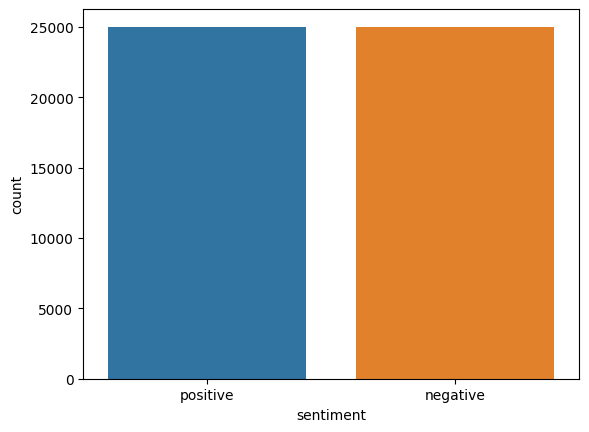

In [54]:
sns.countplot(df, x='sentiment')

In [55]:
print("There are: positive", len(df[df["sentiment"]=="positive"]))
print("There are: negative", len(df[df["sentiment"]=="negative"]))

There are: positive 25000
There are: negative 25000


It seems we have the same number of instances for each class thus stratifying wouldn't be necessary and an 80/20 split should be sufficient enought. 

## Text Clean Up

### Clean Up HTML

In [56]:
print("Sample: ")
df.review[1000]

Sample: 


"This movie is awful, I can't even be bothered to write a review on this garbage! All i will say it is one of the most boring films I've ever seen.<br /><br />And the acting is very bad. The boy who plays the main character really annoys me, he's got the same expression on his face through out the movie. I just want to slap him! Basically 80% of the movie is slow motion shots of skateboarders, weird music, and utter sh*t..<br /><br />Apparently I've got to write at least 10 lines of text to submit this comment, so I'll use up a few more lines by saying the lead character has got one of those faces you just want to slap!<br /><br />Meh i give up..THIS MOVIE SUCKS !!!!"

In [57]:
def remove_html(data_series):
    return BeautifulSoup(data_series, "html.parser").get_text()

In [58]:
df['review'] = df['review'].apply(remove_html)

/usr/local/lib/python3.9/dist-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


### Clean Up HTTPS

In [59]:
df.review[1088]

"This quasi J-horror film followed a young woman as she returns to her childhood village on the island of Shikoku to sell the family house and meet up with old friends. She finds that one, the daughter of the village priestess, drowned several years earlier. She and Fumiko (another childhood friend) then learn that Sayori's mother is trying to bring her back to life with black magic. Already the bonds between the dead and living are getting weak and the friends and villagers are seeing ghosts. Nothing was exceptional or even very good about this movie. Unlike stellar J-horror films, the suspense doesn't really build, the result doesn't seem overly threatening and the ending borders on the absurd.This movie is like plain white rice cooked a little too long so that it is bordering on mushy. Sometimes you get this at poor Asian restaurants or cook your own white rice a little too long. You end up eating it, because you need it with the meal, because what is Chinese or Japanese food withou

In [60]:
def remove_url(text):
    return re.sub(r'http\S+', '', text)

In [61]:
df['review'] = df['review'].apply(remove_url)

In [62]:
df.review[48033]

"POPEYE AND BIG FOOT **; POPEYE'S ENGINE COMPANY **; GETTING POPEYE'S GOAT **1/2I used to lap these up as a kid but, catching an episode of the series comprising three cartoons back-to-back now i.e. several years later (they preceded the theatrical screening of the pirate yarn RAIDERS OF THE SEVEN SEAS [1953]), I can see how they don't hold up all that well! The character of Popeye isn't exactly sympathetic to begin with, Olive Oyl distinctly overbearing and Bluto's antics failed to elicit much interest either \x96 in short, the scripts were alarmingly thin, fairly awful and generally unfunny to boot. They're strictly juvenile fare, yet I doubt today's kids would even have the patience to stick with them!; furthermore, the animation style is unattractive.Taking each short per se, I guess they improved from one to the other: after the initial shock, one adapted to its mediocre quality as it were, so that the third cartoon easily results in being the most enjoyable of the lot \x96 Popeye

### Clean up text between brackets []

In [63]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [64]:
df['review'] = df['review'].apply(remove_between_square_brackets)

In [65]:
df.review[48033]

"POPEYE AND BIG FOOT **; POPEYE'S ENGINE COMPANY **; GETTING POPEYE'S GOAT **1/2I used to lap these up as a kid but, catching an episode of the series comprising three cartoons back-to-back now i.e. several years later (they preceded the theatrical screening of the pirate yarn RAIDERS OF THE SEVEN SEAS ), I can see how they don't hold up all that well! The character of Popeye isn't exactly sympathetic to begin with, Olive Oyl distinctly overbearing and Bluto's antics failed to elicit much interest either \x96 in short, the scripts were alarmingly thin, fairly awful and generally unfunny to boot. They're strictly juvenile fare, yet I doubt today's kids would even have the patience to stick with them!; furthermore, the animation style is unattractive.Taking each short per se, I guess they improved from one to the other: after the initial shock, one adapted to its mediocre quality as it were, so that the third cartoon easily results in being the most enjoyable of the lot \x96 Popeye is en

### Clean up stop words

In [66]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [68]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

In [69]:
df['review'] = df['review'].apply(remove_stopwords)

### Sentences Length Distribution ?

In [70]:
text_lens = df['review'].str.len()

In [71]:
print("Mean: {} - Max: {}".format(str(text_lens.mean()), str(text_lens.max())))
print("Standard Deviation: " + str(text_lens.std()))

Mean: 617.99234 - Max: 7593
Standard Deviation: 482.8162404805433


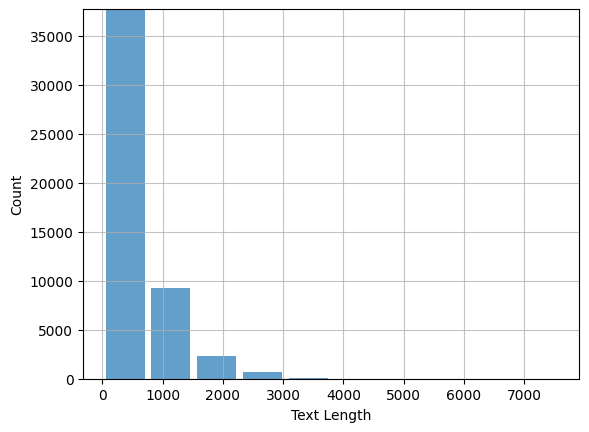

In [72]:
n, bins, patches = pyplot.hist(text_lens,alpha=0.7,rwidth=0.85)
pyplot.grid(axis='both', alpha=0.75)
# pyplot.axis([0,5000,0,40000])
# pyplot.xticks(range(20))
pyplot.xlabel('Text Length')
pyplot.ylabel('Count')

maxfreq = n.max()

pyplot.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
pyplot.show()

I think it would be safe to go with ~ 1500

## Categorize Sentiment Column

In [73]:
df['sentiment'] = df['sentiment'].astype('category')
df['sentiment'] = df['sentiment'].cat.codes

# Split the data into training and testing

**How you performed this split and why you think it is reasonable to split this particular dataset this way** 

The number of positive and negative samples given are equal. There are 25000 samples of each sentiment. Thus our data is balanced so no need to stratify , undersample or oversample the data. The dataset has a total of 50,000 instances; thus it is sufficient to go with an 80/20 split. [Ref](https://www.baeldung.com/cs/train-test-datasets-ratio#:~:text=If%20we%20search%20the%20Internet,even%20a%2050%3A50%20split.) 

## Setting Up Data for CNN Training 

In [74]:
MAX_ART_LEN = 1000
NUM_CLASSES = 1

In [75]:
# Tokenizer function
# sentences : can be a list of strings, a generator of strings, or a list of list of strings
# target_labels : List of the target labels to one hot encode them. 
# num_top_words : Number of vocabs. If set to NONE - Use the entire vocabulary
# max_art_length : Maximum and Minumum number of words

def tokenize(sentences, target_labels, num_top_words, max_art_length):
    #tokenize the text
    tokenizer = Tokenizer(num_words=num_top_words)
    tokenizer.fit_on_texts(sentences)

    # save as sequences with integers replacing words
    sequences = tokenizer.texts_to_sequences(sentences)

    word_index = tokenizer.word_index
    num_top_words = len(word_index) if num_top_words==None else num_top_words
    top_words = min((len(word_index), num_top_words))
    print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

    X = pad_sequences(sequences, maxlen=max_art_length)
    y_ohe = None
    if target_labels is not None:
        y_ohe = keras.utils.to_categorical(target_labels)
    return word_index, X, y_ohe

In [76]:
word_index, X, _ = tokenize(
    df['review'],
    df['sentiment'],
    None,
    MAX_ART_LEN
)

Found 83538 unique tokens. Distilled to 83538 top words.


In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    df['sentiment'], 
    test_size=0.2,
    random_state=42
)

# Training a CNN Model

In [78]:
def get_cnn_model(max_art_len, embedding_layer, num_classes):
    sequence_input = Input(shape=(max_art_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(filters= 128, kernel_size=3, activation='relu', kernel_initializer='he_uniform')(embedded_sequences)
    x = Dropout(rate= 0.5)(x)
    x = MaxPooling1D(pool_size = 2)(x) #Strides defaults to pooling size
    
    x = Conv1D(filters= 128, kernel_size=6, activation='relu',kernel_initializer='he_uniform')(x)
    x = Dropout(rate= 0.5)(x)
    x = MaxPooling1D(pool_size = 4)(x) #Strides defaults to pooling size
    
    x = Conv1D(filters=128, kernel_size=5, activation='relu', kernel_initializer='he_uniform')(x)
    x = MaxPooling1D(pool_size = 2)(x) #Strides defaults to pooling size
    x = Dropout(rate= 0.5)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate= 0.5)(x)
    x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate= 0.5)(x)
    x = Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate= 0.2)(x)
    
    preds = Dense(num_classes, activation='sigmoid',
                  kernel_initializer='glorot_uniform')(x)

    model = Model(sequence_input, preds, name="CNN_MODEL")
    
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.95,
        staircase=True
    ) 

    opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy', fbeta_local]
    )
    return model

In [80]:
cnn_model = None
cnn_model_histories = []
if LOAD_MODELS:
    print("Loading Model ...")
    cnn_model = load_model("CNN_MODEL")
    cnn_model_histories = load_history("CNN_MODEL")
else: 
    embedding_layer_numberbatch = define_embedding_layer(
        300,
        number_batch_embedding, #Use the entire numberbatch embedding and not the smaller version of vocab embedding_matrix_numberbatch
        MAX_ART_LEN
    )

    cnn_model_histories = []
    cnn_model = get_cnn_model(
        MAX_ART_LEN, 
        embedding_layer_numberbatch, 
        NUM_CLASSES
    )

print(cnn_model.summary())

Loading Model ...
Model: "CNN_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1000)]            0         
                                                                 
 embedding_17 (Embedding)    (None, 1000, 300)         125424300 
                                                                 
 conv1d_46 (Conv1D)          (None, 998, 128)          115328    
                                                                 
 dropout_53 (Dropout)        (None, 998, 128)          0         
                                                                 
 max_pooling1d_46 (MaxPoolin  (None, 499, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_47 (Conv1D)          (None, 494, 128)          98432     
                                       

**For training a model from scratch to perform the sentiment analysis task we chose a CNN. This CNN will take in as an input an encoded sequence using ConceptNet.**

In [151]:
%%time

train_model(
    model = cnn_model,
    train_data = X_train,
    train_labels = y_train,
    test_data = X_test,
    test_labels = y_test,
    epochs = 10,
    batch_size = 128,
    histories = cnn_model_histories,
    save_model = True,
    verbose = 1
)

Length of training data 40000
Training model CNN_MODEL ...
Epoch 1/10
313/313 [==============================] - 16s 50ms/step - loss: 0.1421 - accuracy: 0.9440 - fbeta_local: 0.9467 - val_loss: 0.5288 - val_accuracy: 0.7797 - val_fbeta_local: 0.8409
Epoch 2/10
312/313 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.9473 - fbeta_local: 0.9483
Epoch 2: saving model to ./checkpoints/checkpoint_CNN_MODEL.ckpt
313/313 [==============================] - 16s 51ms/step - loss: 0.1375 - accuracy: 0.9473 - fbeta_local: 0.9484 - val_loss: 0.5026 - val_accuracy: 0.7880 - val_fbeta_local: 0.8217
Epoch 3/10
313/313 [==============================] - 15s 48ms/step - loss: 0.1394 - accuracy: 0.9459 - fbeta_local: 0.9462 - val_loss: 0.4956 - val_accuracy: 0.7820 - val_fbeta_local: 0.8221
Epoch 4/10
311/313 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9472 - fbeta_local: 0.9456
Epoch 4: saving model to ./checkpoints/checkpoint_CNN_MODEL.ckpt
313/313 [=

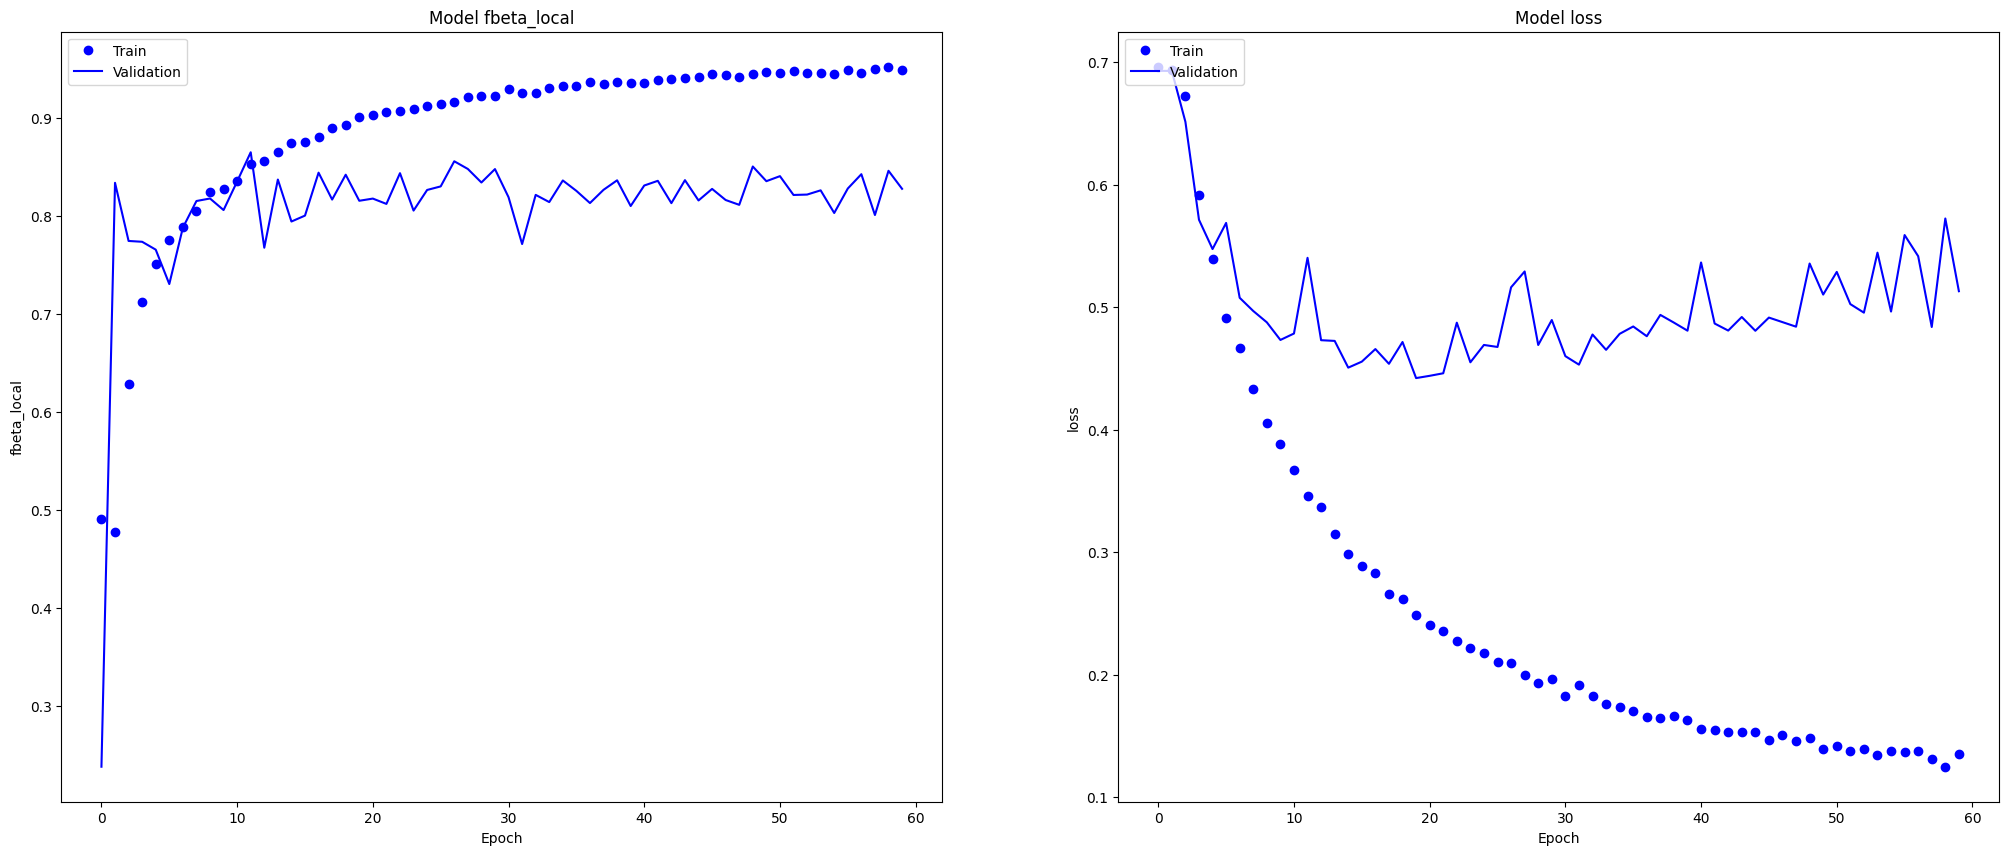

In [81]:
plot_learning_curves(
    cnn_model.name,
    METRICS_TO_PLOT,
    METRICS_IN_HISTORIES,
    cnn_model_histories
)

# Transfer Learning

**Describe the foundational model:**

BERT is a bidirectional encoder representation from Transformers. It consists of 12 attention heads . Embedding dimension of 768 and a total of 110 million parameters. It uses a vocabulary of about 30,000 tokens. This is the default vocabulary size which refers to the number of different units(words, subwords, special characters)  that the model can represent.


**What tasks was this foundational model trained upon?:** 

Transformer model pre-trained on a large corpus of English data in a self-supervised fashion This model is case-sensitive (i.e. it makes a difference between english and English). It was pre-trained with 2 objectives: 
* Masked language modeling: The model would randomly mask 15% of the words in the input and then run the entire masked sentence through the model and it has to predict the masked words. 
* Next Sentence prediction: The model would concatenate two masked sentences as inputs and the model has to predict if the two sentence were following each other or not.  [1](https://huggingface.co/google-bert/bert-base-cased). 


**Explain if the new task is within the same domain, across domains, etc.**

The new task of sentiment analysis is within the same domain which is text classification/ text prediction. The CLS output of the model is considered a sufficient enough representation of the sentences to utilize for text classification tasks (i.e. It contains BERT’s understanding at the sentence-level)

## Loading BERT Model and BERT Tokenizer

In [82]:
print_gpu_usage()
print("Loading BERTS ...")
## Load tokenizer and the pre-trained bert model
bert_base_cased_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_base_cased_model = TFBertModel.from_pretrained('bert-base-cased')
print("Done...")
print_gpu_usage()

GPU Peak Memory:  1.4672436714172363 G
Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.
GPU Current Memory Usage:  0.5071604251861572 G
Loading BERTS ...


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Done...
GPU Peak Memory:  1.4672436714172363 G
GPU Current Memory Usage:  0.9208548069000244 G


## General Transfer Learning Config Variables

In [83]:
batch_size = 16
max_encoding_length = 512
bert_out_dimension = 768

## Extracting Bottleneck Features

In [58]:
def save_bottleneck(bert_model, tokenizer, ds, batch_size, max_length, filename_addendum, verbose=False):
    bottleneck_features = []
    labels_train = []
    
    batch_num = 1
    for i in range(0, ds.shape[0], batch_size):
        batch = ds.iloc[i:i+batch_size].review.tolist()
        inputs = tokenizer(
            text=batch,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding=True,
            return_tensors='tf',
            return_token_type_ids=False,
            return_attention_mask=True,
            verbose=True
        )
        
        out = bert_model(inputs)
        bottleneck_features.extend(out.pooler_output)
        labels_train.extend(ds.iloc[i:i+batch_size].sentiment)
        
        del out
        if verbose and batch_num % 500 == 0:
            print("Batch {} - size {}".format(batch_num, len(batch)))
            print_gpu_usage()
        batch_num = batch_num + 1
    
    print("Total Number of batches {} - Length of bottleneck features {}".format(batch_num, len(bottleneck_features)))
    bottleneck_features = np.array(bottleneck_features)
    labels_train = np.array(labels_train)
    data_filename = './bottleneckFeatures/bottleneck_features_{}_{}.npy'.format(filename_addendum, max_length)
    labels_filename = './bottleneckFeatures/bottleneck_labels_{}_{}.npy'.format(filename_addendum, max_length)
    np.save(data_filename, bottleneck_features)
    np.save(labels_filename, labels_train)
    
    return data_filename, labels_filename

In [84]:
df_train, df_test = train_test_split(
    df, 
    test_size=0.2,
    random_state=42
)

In [85]:
%%time
if LOAD_MODELS:
    train_bottlenck_feature_file = './bottleneckFeatures/bottleneck_features_{}_{}.npy'.format("train", 512)
    train_labels_file = './bottleneckFeatures/bottleneck_labels_{}_{}.npy'.format("train", 512)
else:
    train_bottlenck_feature_file, train_labels_file = save_bottleneck(
        bert_model = bert_base_cased_model,
        tokenizer= bert_base_cased_tokenizer,
        ds = df_train,
        batch_size = batch_size, 
        max_length = max_encoding_length,
        filename_addendum = 'train',
        verbose = True
    )

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 15 µs


In [86]:
%%time
if LOAD_MODELS:
    test_bottlenck_feature_file = './bottleneckFeatures/bottleneck_features_{}_{}.npy'.format("test", 512)
    test_labels_file = './bottleneckFeatures/bottleneck_labels_{}_{}.npy'.format("test", 512)
else:
    test_bottlenck_feature_file, test_labels_file = save_bottleneck(
        bert_model = bert_base_cased_model,
        tokenizer= bert_base_cased_tokenizer,
        ds = df_test,
        batch_size = batch_size, 
        max_length = max_encoding_length,
        filename_addendum = 'test',
        verbose = True
    )

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.8 µs


In [62]:
def load_bottleneck(train_x_file, train_y_file, test_x_file, test_y_file):
    # Load bottleneck features that have already been extracted by base model
    train_data = np.load(train_x_file)
    train_labels = np.load(train_y_file)
    print('Training Data Shape: ',train_data.shape, 'Training Label Shape: ',train_labels.shape)

    test_data = np.load(test_x_file)
    test_labels = np.load(test_y_file)
    print('Val Data Shape: ',test_data.shape, 'Val Label Shape: ', test_labels.shape)
    return train_data, train_labels, test_data, test_labels

In [87]:
train_data, train_labels, test_data, test_labels = load_bottleneck(
    train_x_file = train_bottlenck_feature_file, 
    train_y_file = train_labels_file,
    test_x_file = test_bottlenck_feature_file, 
    test_y_file = test_labels_file
)

NameError: name 'load_bottleneck' is not defined

## Train Top Model On Bottleneck Features

### Top Model Description

In [60]:
def get_top_model():
    sequence_input = Input(shape=(bert_out_dimension,))
    
    x = layers.Dense(512, activation='relu')(sequence_input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    preds = layers.Dense(1, activation='sigmoid')(x)

    top_model = Model(sequence_input, preds, name="TOP_MODEL")
    
    top_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', fbeta_local]
    )

    return top_model

In [88]:
top_model = None
top_model_with_bottlenecks = []
if LOAD_MODELS:
    print("Loading Model ...")
    top_model = load_model("TOP_MODEL")
    top_model_with_bottlenecks = load_history("TOP_MODEL")
else: 
    top_model = get_top_model()

top_model.summary()

Loading Model ...
Model: "TOP_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_136 (Dense)           (None, 512)               393728    
                                                                 
 dropout_164 (Dropout)       (None, 512)               0         
                                                                 
 dense_137 (Dense)           (None, 256)               131328    
                                                                 
 dropout_165 (Dropout)       (None, 256)               0         
                                                                 
 dense_138 (Dense)           (None, 128)               32896     
                                                                 
 dropout_166 (Dropout)       (None, 128

**The top model to be trained on extracted bottleneck features(freezing all the bert layers) is merely a simple MLP consisting of 3 Dense layers and a final prediction layer. The number of trainable parameters is 558,081.**

In [274]:
%%time
train_model(
    model = top_model, 
    train_data = train_data,
    train_labels = train_labels, 
    test_data = test_data,
    test_labels = test_labels,
    epochs = 10, 
    batch_size = 64,
    histories = top_model_with_bottlenecks
)

Length of training data 40000
Training model TOP_MODEL ...
Epoch 1/10
625/625 [==============================] - 25s 39ms/step - loss: 0.6511 - accuracy: 0.6060 - fbeta_local: 0.5781 - val_loss: 0.6140 - val_accuracy: 0.7014 - val_fbeta_local: 0.7292
Epoch 2/10
623/625 [============================>.] - ETA: 0s - loss: 0.6477 - accuracy: 0.6121 - fbeta_local: 0.5934
Epoch 2: saving model to ./checkpoints/checkpoint_TOP_MODEL.ckpt
625/625 [==============================] - 25s 40ms/step - loss: 0.6477 - accuracy: 0.6121 - fbeta_local: 0.5933 - val_loss: 0.6032 - val_accuracy: 0.7257 - val_fbeta_local: 0.7297
Epoch 3/10
625/625 [==============================] - 25s 40ms/step - loss: 0.6502 - accuracy: 0.6054 - fbeta_local: 0.5765 - val_loss: 0.6158 - val_accuracy: 0.7116 - val_fbeta_local: 0.7370
Epoch 4/10
623/625 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.6076 - fbeta_local: 0.5818
Epoch 4: saving model to ./checkpoints/checkpoint_TOP_MODEL.ckpt
625/625 [=

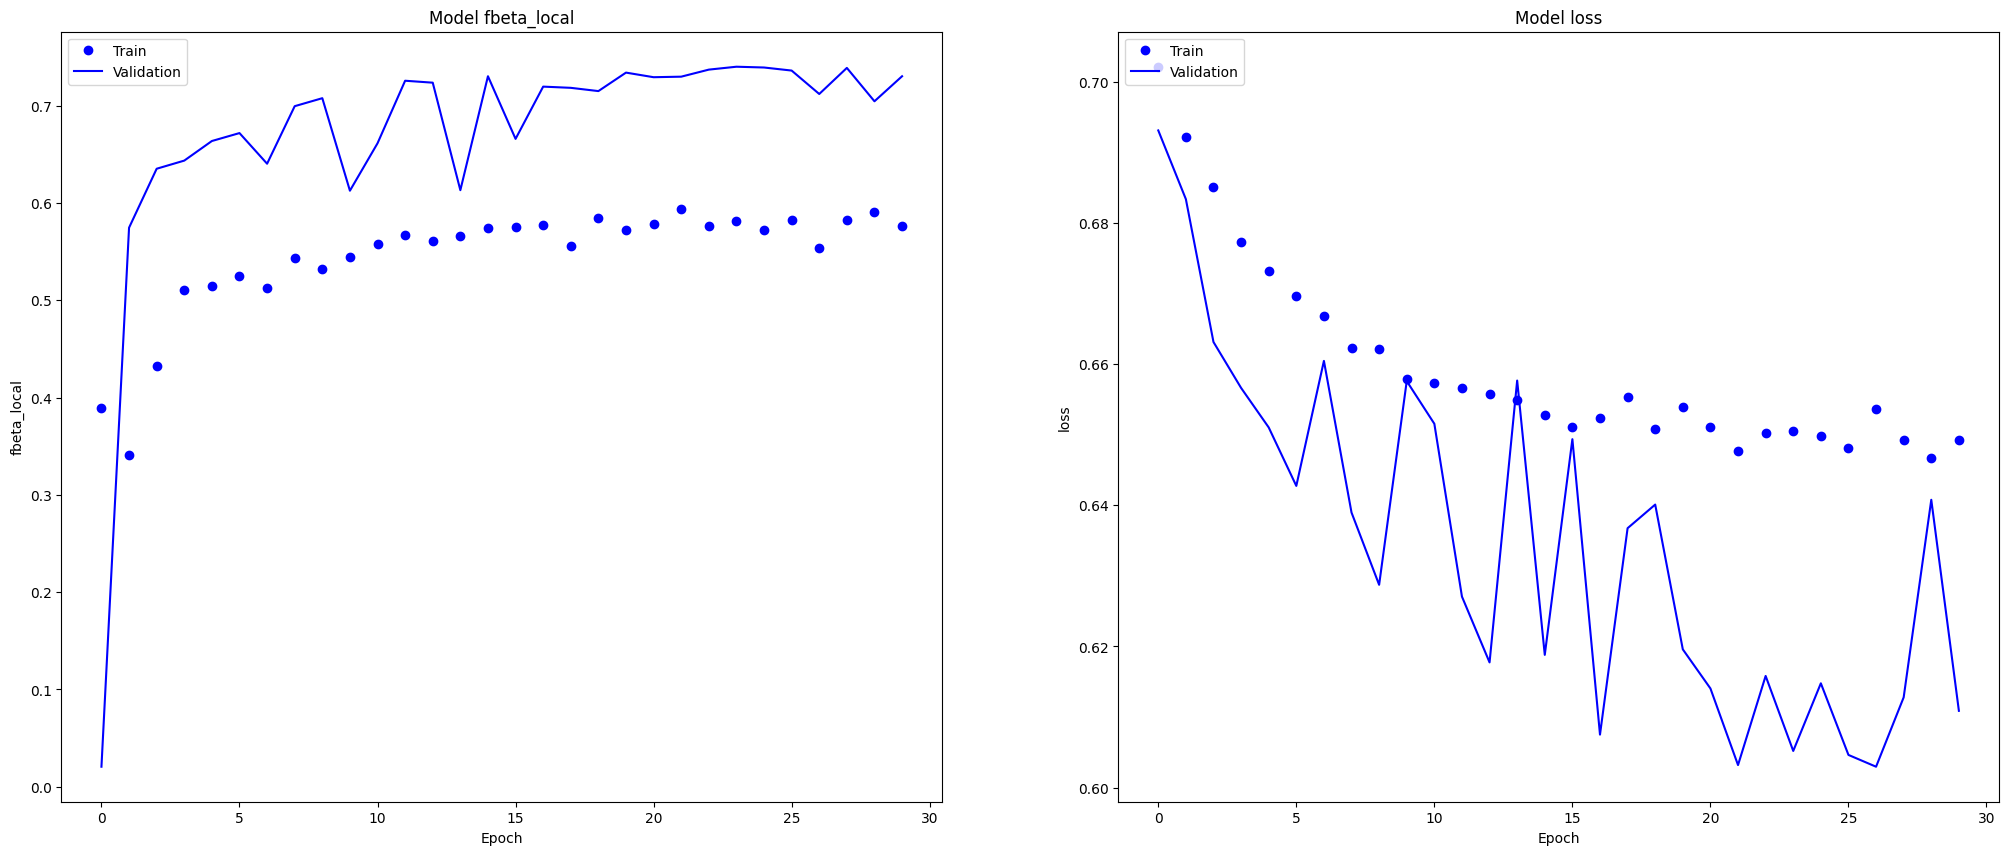

In [89]:
plot_learning_curves(
    top_model.name, 
    METRICS_TO_PLOT,
    METRICS_IN_HISTORIES,
    top_model_with_bottlenecks
)

## Fine Tuning

In [91]:
def get_combined_model(bert_base_model, top_model, max_tokenization_len):
    in_id = tf.keras.layers.Input(shape=(max_tokenization_len,), name="input_ids", dtype='int32')
    in_mask = tf.keras.layers.Input(shape=(max_tokenization_len,), name="input_masks",dtype='int32')
    
    for layer in bert_base_model.layers[:]:
        if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
            for encoder_layer in layer.encoder.layer:
                if encoder_layer.name == 'layer_._11':
                    print("Setting TRUE")
                    encoder_layer.trainable = True
                else:
                    encoder_layer.trainable = False
            layer.embeddings.trainable = False
            layer.pooler.trainable = False

    model = tf.keras.Model(
        inputs=[in_id, in_mask] , 
        outputs=top_model(bert_base_model({'input_ids':in_id, 'attention_mask':in_mask})[1]),
        name = "COMBINED_MODEL"
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
        metrics=[
            'accuracy',
            fbeta_local
        ]
    )
    
    return model

In [92]:
combined_model = None
combined_model_histories = []
if LOAD_MODELS:
    print("Loading Model ...")
    combined_model = get_combined_model(
        bert_base_cased_model,
        top_model,
        max_encoding_length
    )
    load_weights_from_checkpoints(combined_model, "COMBINED_MODEL")
    combined_model_histories = load_history("COMBINED_MODEL")
else: 
    combined_model = get_combined_model(
        bert_base_cased_model,
        top_model,
        max_encoding_length
    )

combined_model.summary()

Loading Model ...
Setting TRUE
Model: "COMBINED_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_masks[0][0]',            
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 512,   

**We will only enable training for the 12th layer encoder of BERT, with that the number of trainable parameters have increased from 558,081 to 7,645,953.**

In [77]:
%%time
train_tokenized = bert_base_cased_tokenizer(
    text=df_train.review.tolist(),
    add_special_tokens=True,
    max_length=max_encoding_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

CPU times: user 15 s, sys: 1.62 s, total: 16.6 s
Wall time: 5.56 s


In [78]:
%%time
test_tokenized = bert_base_cased_tokenizer(
    text=df_test.review.tolist(),
    add_special_tokens=True,
    max_length=max_encoding_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

CPU times: user 3.41 s, sys: 429 ms, total: 3.84 s
Wall time: 1.15 s


In [115]:
%%time
print_gpu_usage()
train_model(
    model = combined_model,
    train_data = {'input_ids': train_tokenized['input_ids'],'input_masks':train_tokenized['attention_mask']},
    train_labels = df_train['sentiment'],
    test_data = {'input_ids':test_tokenized['input_ids'], 'input_masks':test_tokenized['attention_mask']},
    test_labels = df_test['sentiment'],
    epochs = 5,
    batch_size = 16,
    histories = combined_model_histories,
    save_model = True,
    verbose = 1
)
print_gpu_usage()

GPU Peak Memory:  35.875473976135254 G
GPU Current Memory Usage:  1.2368268966674805 G
Length of training data 40000
Training model COMBINED_MODEL ...
Epoch 1/5
2500/2500 [==============================] - 817s 327ms/step - loss: 0.3680 - accuracy: 0.8431 - fbeta_local: 0.8425 - val_loss: 0.3580 - val_accuracy: 0.8420 - val_fbeta_local: 0.8585
Epoch 2/5
2499/2500 [============================>.] - ETA: 0s - loss: 0.3655 - accuracy: 0.8431 - fbeta_local: 0.8429
Epoch 2: saving model to ./checkpoints/checkpoint_COMBINED_MODEL.ckpt
2500/2500 [==============================] - 817s 327ms/step - loss: 0.3656 - accuracy: 0.8430 - fbeta_local: 0.8429 - val_loss: 0.3504 - val_accuracy: 0.8451 - val_fbeta_local: 0.8554
Epoch 3/5
2500/2500 [==============================] - 816s 326ms/step - loss: 0.3633 - accuracy: 0.8462 - fbeta_local: 0.8469 - val_loss: 0.3445 - val_accuracy: 0.8511 - val_fbeta_local: 0.8485
Epoch 4/5
2499/2500 [============================>.] - ETA: 0s - loss: 0.3657 - accur

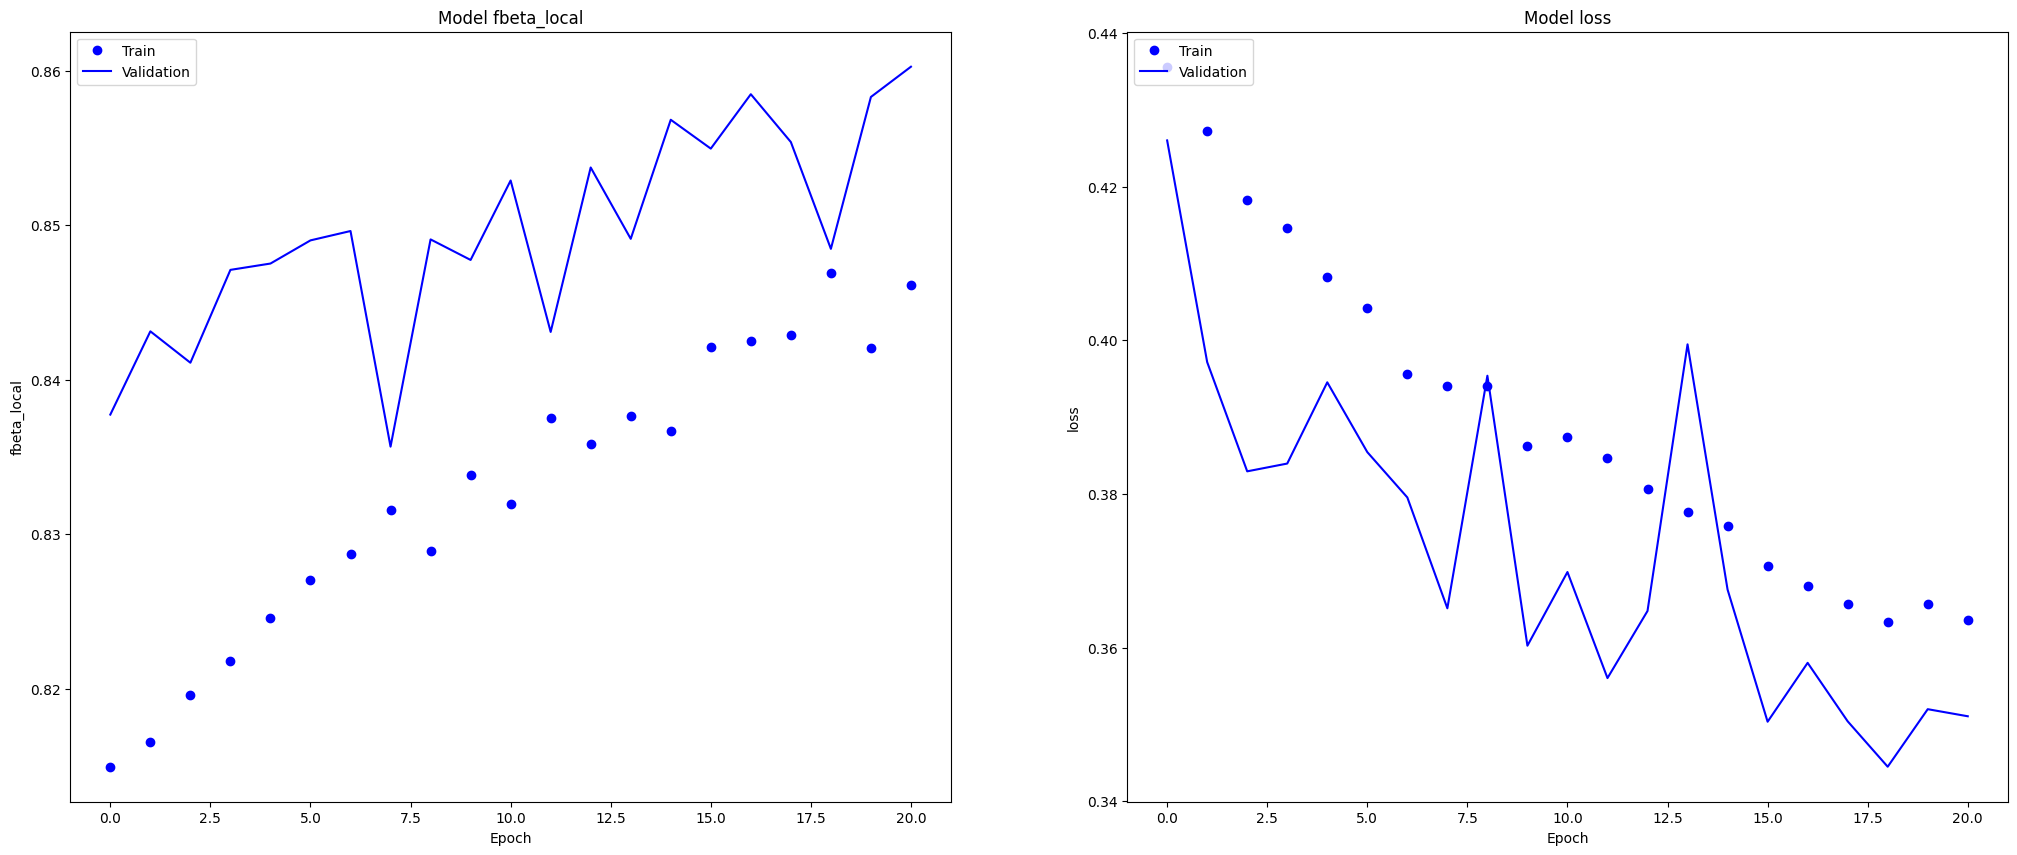

In [93]:
plot_learning_curves(
    combined_model.name, 
    METRICS_TO_PLOT,
    METRICS_IN_HISTORIES,
    combined_model_histories
)

# Results

**Compare the convergence of the models and the running time.**

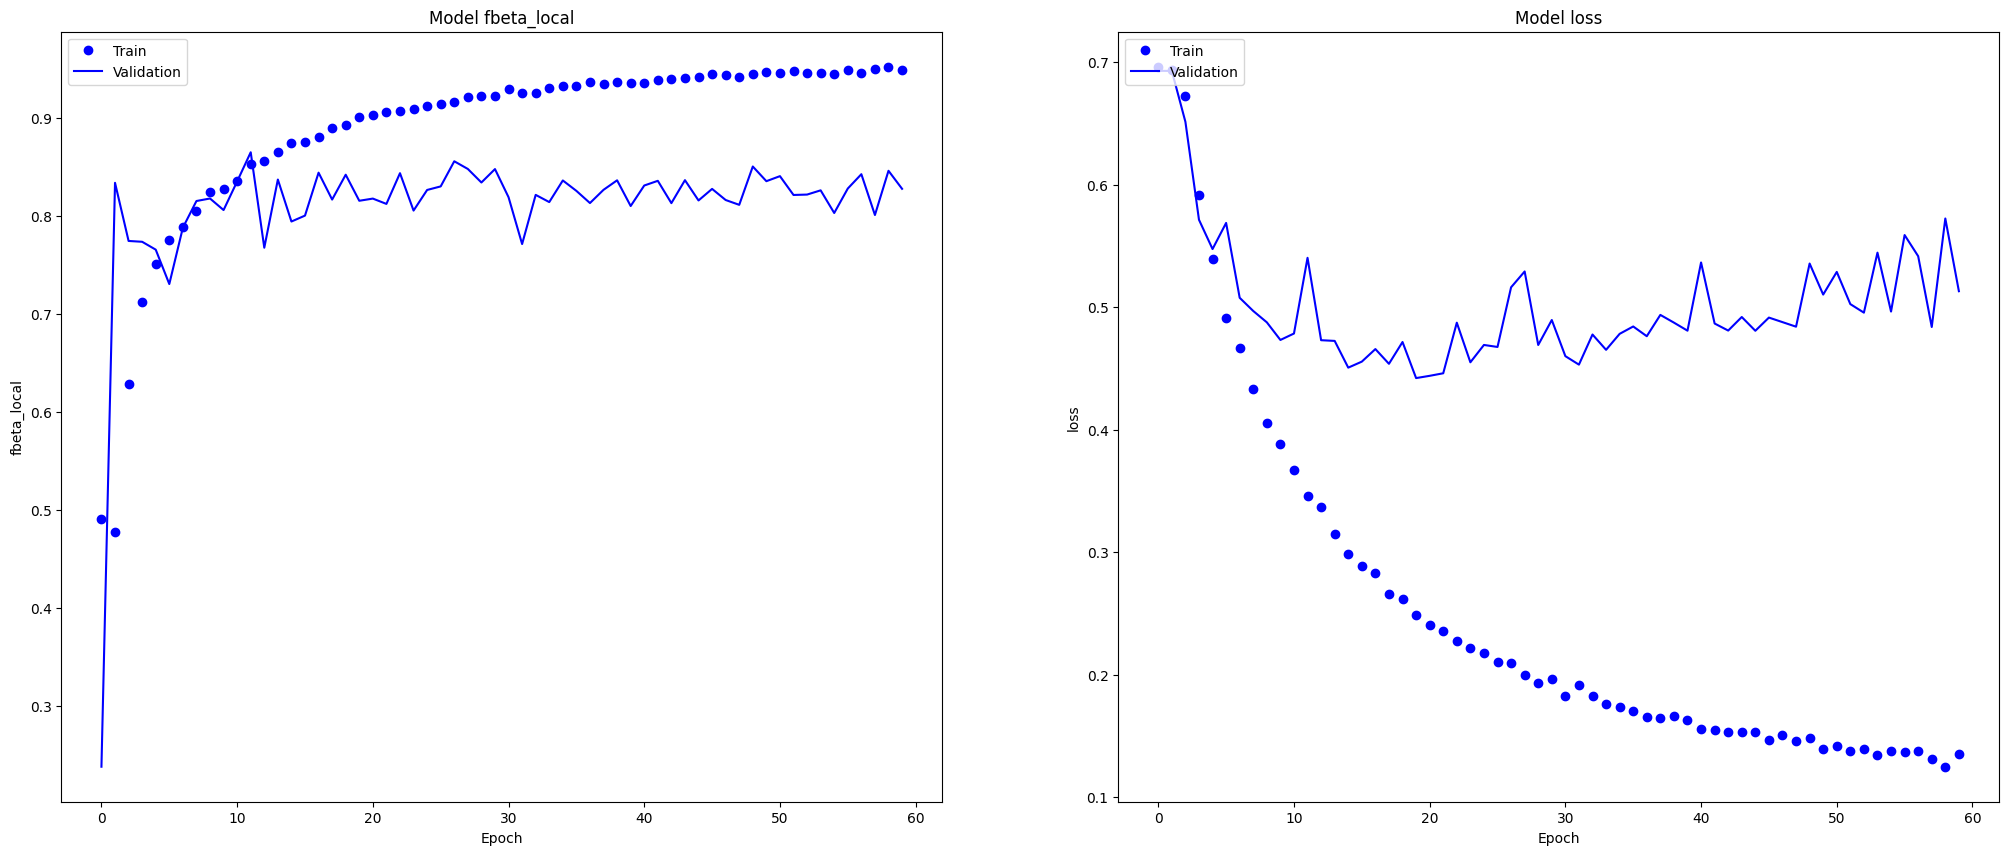

In [105]:
plot_learning_curves(
    cnn_model.name,
    METRICS_TO_PLOT,
    METRICS_IN_HISTORIES,
    cnn_model_histories
)

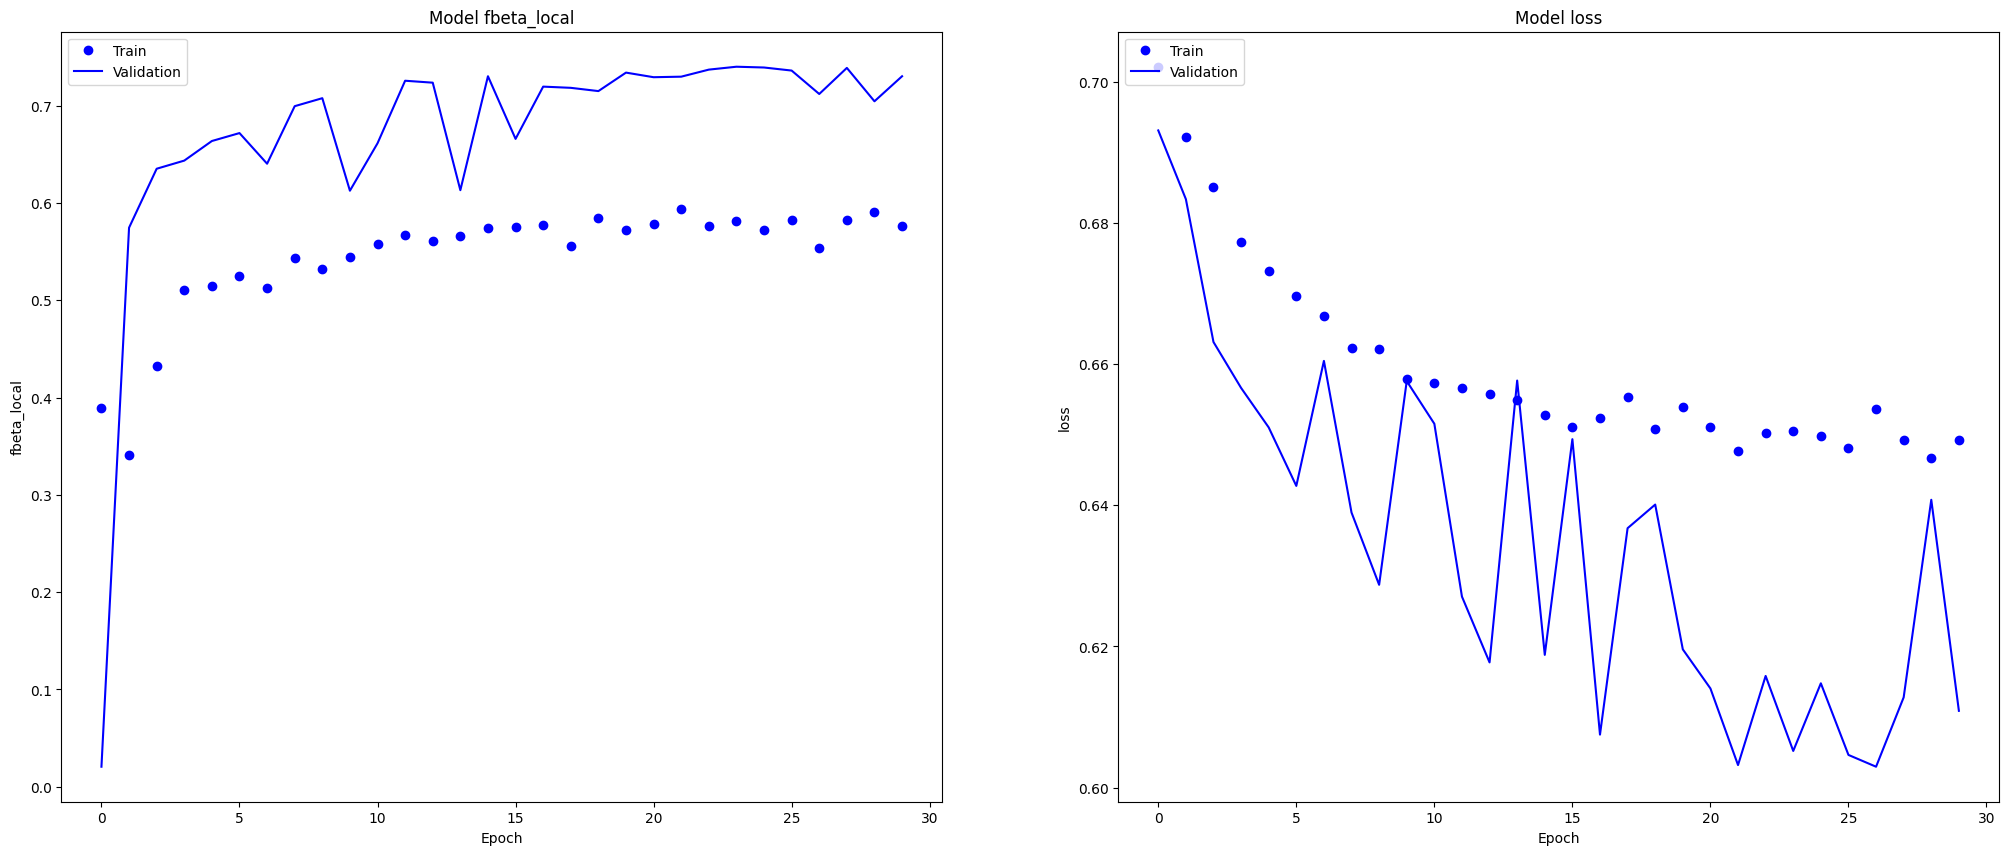

In [106]:
plot_learning_curves(
    top_model.name, 
    METRICS_TO_PLOT,
    METRICS_IN_HISTORIES,
    top_model_with_bottlenecks
)

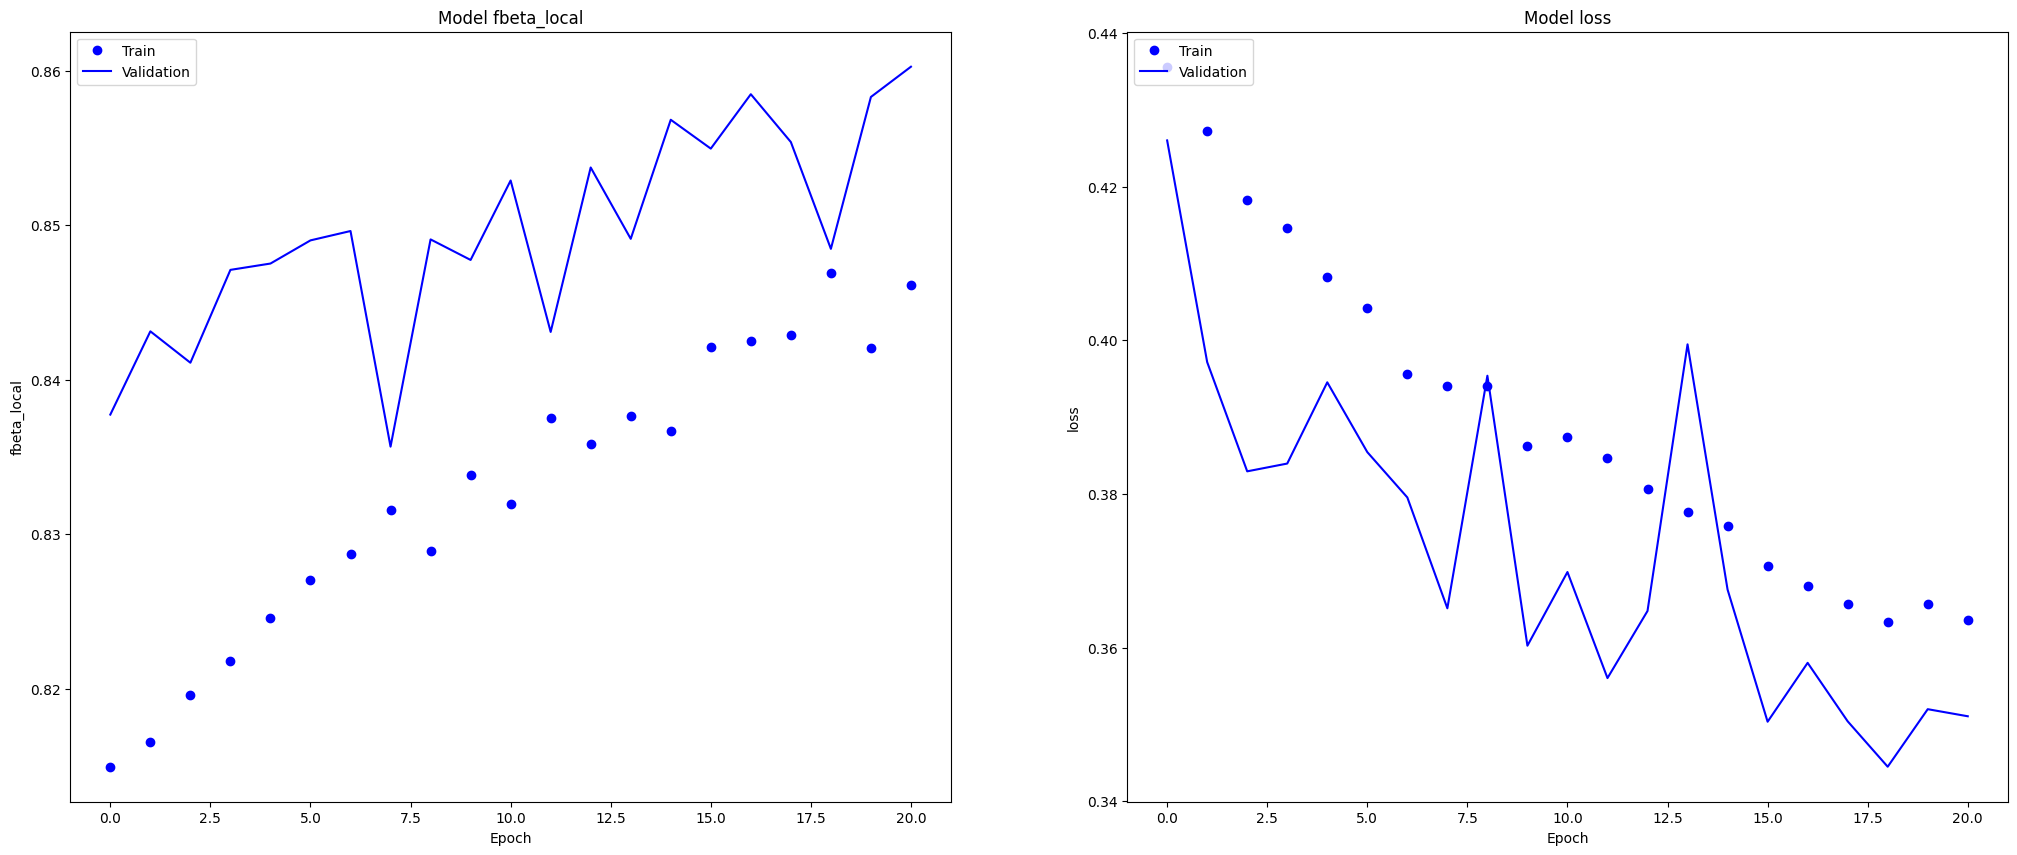

In [107]:
plot_learning_curves(
    combined_model.name, 
    METRICS_TO_PLOT,
    METRICS_IN_HISTORIES,
    combined_model_histories
)

Training the combined model (Fine tuned) definitely had the highest training time per epoch (~11min/epoch). Training the top_model alone or the CNN were faster. 
* CNN: Although we ended up with some overfitting - it does somewhat converge within 20-30 epochs. 
* Top_model trained on bottleneck overfits kind of quickly. Potentially with more dropouts it would have helped in lowering the overfitting. 
* Fine Tuning: With limited resources we didn’t get the convergence plot. We note that the validation fbeta_score although not smooth in its trend, continued to be higher than the training fbeta_score over the epochs. Also, the loss is trending down as one expects, yes not smooth however with more training epochs we expected to get better. 


**Statistical Comparision**

In [94]:
def get_variance_subtracted_error_states(n_1, error_1, n_2, error_2):
    one = (error_1 * (1 - error_1)) / n_1
    two = (error_2 * (1 - error_2)) / n_2
    return one + two

def get_mean_difference(error_1, error_2):
    return abs(error_1 - error_2)

In [95]:
def compare_models(test_data_len, model_one_history_dict, model_two_history_dict):
    model_one_error_avg = np.average(model_one_history_dict['val_loss'])
    model_two_error_avg = np.average(model_two_history_dict['val_loss'])
    
    segma = get_variance_subtracted_error_states(
        test_data_len,
        model_one_error_avg,
        test_data_len,
        model_two_error_avg
    )
    
    d = get_mean_difference(model_one_error_avg, model_two_error_avg)
    return d-segma, d+segma

In [96]:
cnn_history_dict = combine_histories(METRICS_IN_HISTORIES, cnn_model_histories)
top_model_history_dict = combine_histories(METRICS_IN_HISTORIES, top_model_with_bottlenecks)
fine_tuned_history_dict = combine_histories(METRICS_IN_HISTORIES, combined_model_histories)

In [101]:
# Compare CNN to top_model trained on bottleneck features
lower_range, upper_range = compare_models(df_test.shape[0], cnn_history_dict, top_model_history_dict)
print("Confidence range comparing CNN to top_model trained on bottleneck features is {}-{}.".format(lower_range, upper_range))
print("Average fbeta_score for CNN : {}".format(np.average(cnn_history_dict['val_fbeta_local'])))
print("Average fbeta_score for TOP_MODEL : {}".format(np.average(top_model_history_dict['val_fbeta_local'])))

Confidence range comparing CNN to top_model trained on bottleneck features is 0.13169176630091733-0.13178816088128037.
Average fbeta_score for CNN : 0.8101154548426469
Average fbeta_score for TOP_MODEL : 0.6723817707970738


* Given the range does not include `0.0` -> Thus we can say with statistical confidence that these estimates are different from one another -> Thus one of them is better than the other. 
* Given higher average fbeta score for CNN and due to the confidence range we can say statistically speaking CNN performed better than the TOP_MODEL.

In [102]:
# Compare CNN to fine tuned model
lower_range, upper_range = compare_models(df_test.shape[0], cnn_history_dict, fine_tuned_history_dict)
print("Confidence range comparing CNN to fine tuned model is {}-{}".format(lower_range, upper_range))
print("Average fbeta_score for CNN : {}".format(np.average(cnn_history_dict['val_fbeta_local'])))
print("Average fbeta_score for Fine Tuned : {}".format(np.average(fine_tuned_history_dict['val_fbeta_local'])))

Confidence range comparing CNN to fine tuned model is 0.12939188885708797-0.12948866492773647
Average fbeta_score for CNN : 0.8101154548426469
Average fbeta_score for Fine Tuned : 0.8494959729058402


* Given the range does not include `0.0` -> Thus we can say with statistical confidence that these estimates are different from one another -> Thus one of them is better than the other. 
* Given higher average fbeta score for Fine Tuned and due to the confidence range we can say statistically speaking Fine Tuned performed better than the CNN.

In [104]:
# Compare top_model trained on bottleneck features to fine tuned model
lower_range, upper_range = compare_models(df_test.shape[0], top_model_history_dict, fine_tuned_history_dict)
print("Confidence range comparing top_model trained on bottleneck features to fine tuned model is {}-{}".format(lower_range, upper_range))
print("Average fbeta_score for TOP_MODEL : {}".format(np.average(top_model_history_dict['val_fbeta_local'])))
print("Average fbeta_score for Fine Tuned : {}".format(np.average(fine_tuned_history_dict['val_fbeta_local'])))

Confidence range comparing top_model trained on bottleneck features to fine tuned model is 0.26113365390624826-0.2612268270607739
Average fbeta_score for TOP_MODEL : 0.6723817707970738
Average fbeta_score for Fine Tuned : 0.8494959729058402


* Given the range does not include `0.0` -> Thus we can say with statistical confidence that these estimates are different from one another -> Thus one of them is better than the other. 
* Given higher average fbeta score for Fine Tuned and due to the confidence range we can say statistically speaking Fine Tuned performed better than the TOP_MODEL.